# Chess Piece Image Classifier

## Project Definition
The goal of this project is to build an image classification system using the fastai library that can automatically recognize chess pieces from images.

Given an input image of a single chess piece, the model should correctly classify it into one of the following predefined classes: King, Queen, Rook, Bishop, Knight, Pawn.

This is a supervised multiclass image classification problem, where each image is labeled with exactly one class corresponding to the chess piece shown.

The use cases for this project include digital chess boards, chess analytics tools, robotics in chess playing machines, and educational applications for learning chess.

This is a challenging problem from a machine learning perspective due to the visual similarity between certain chess pieces (e.g., Bishop and Queen) and the need for the model to generalize well across different styles and designs of chess pieces. In addition, the images are from the real world, which introduces variability in lighting, angles, and backgrounds.

## Dataset Creation and Preparation
### How the images were collected
The images were imported from a two public chess piece image dataset available on Kaggle. The datasets were downloaded programmatically using the Kaggle API via kagglehub.
Authentication is handled via a local kaggle.json file, which is not included in the repository for security reasons.

The datasets contain a variety of chess piece images, icons, and illustrations, covering all six standard chess pieces: King, Queen, Rook, Bishop, Knight, and Pawn.

Two datasets were imported rather than one because each dataset individually had a limited number of images per class (around 50-100). By combining the two datasets, a larger and more diverse set of images was obtained, which is beneficial for training a robust image classification model.

In [1]:
import kagglehub

path_one = kagglehub.dataset_download("anshulmehtakaggl/chess-pieces-detection-images-dataset")
path_two = kagglehub.dataset_download("niteshfre/chessman-image-dataset")

print(f"Dataset one downloaded to: {path_one}")
print(f"Dataset two downloaded to: {path_two}")

C:\Users\seanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset one downloaded to: C:\Users\seanb\.cache\kagglehub\datasets\anshulmehtakaggl\chess-pieces-detection-images-dataset\versions\31
Dataset two downloaded to: C:\Users\seanb\.cache\kagglehub\datasets\niteshfre\chessman-image-dataset\versions\1


## Cleaning and Filtering
After inspecting the datasets, no aggressive cleaning or filtering was applied beyond basic validation.

Both datasets contain a wide variety of chess piece representations, including real photographed pieces, stylized illustrations, and icon-like and symbolic renderings.

Rather than treating this variability as noise, it was intentionally preserved.

The motivation for this decision is that the core visual signal defining a chess piece is its outline and overall shape, rather than texture, color, or material. Keeping diverse representations encourages the model to learn shape-based features that generalize across different visual styles.

However, it is still necessary to combine the two datasets into a single unified structure for training, by combining images from both datasets into a common folder structure organized by chess piece class.

This was done with a helper function that iterates through both datasets, identifies the chess piece class for each image based on folder names, and copies the images into a new unified directory structure.

In [2]:
from pathlib import Path
import shutil
import uuid

data_root = Path("data/merged_chess_dataset")
data_root.mkdir(parents=True, exist_ok=True)
path_one = Path(path_one)
path_two = Path(f"{path_two}/Chessman-image-dataset/Chess")
image_exts = {".jpg", ".jpeg", ".png", ".webp"}
CLASSES = ["king", "queen", "rook", "bishop", "knight", "pawn"]

# Helper function to infer class from folder name
def infer_class(folder_name: str):
    name = folder_name.lower()
    for cls in CLASSES:
        if cls in name:
            return cls
    return None

# Function to merge datasets
def merge_dataset(src_root: Path, dst_root: Path):
    for folder in src_root.iterdir():
        if not folder.is_dir():
            continue

        cls = infer_class(folder.name)
        if cls is None:
            continue  # skip unrelated folders

        dst_cls = dst_root / cls
        dst_cls.mkdir(parents=True, exist_ok=True)

        for img in folder.iterdir():
            if img.suffix.lower() not in image_exts:
                continue

            new_name = f"{img.stem}_{uuid.uuid4().hex[:8]}{img.suffix}"
            shutil.copy2(img, dst_cls / new_name)

merge_dataset(path_one, data_root)
merge_dataset(path_two, data_root)


### Dataset Structure
The merged dataset is structured in a directory format compatible with fastai's ImageDataLoaders.from_folder method. The root directory contains six subdirectories, one for each chess piece class. Each subdirectory contains all images corresponding to that class.
The classes are: bishop, king, knight, pawn, queen, rook.

Dataset Directory Structure:

In [3]:
print("data/\n\tmerged_chess_dataset/")
for cls in sorted(p for p in data_root.iterdir() if p.is_dir()):
    print(f"\t\t{cls.name}/  ({len(list(cls.glob('*')))} images)")

data/
	merged_chess_dataset/
		bishop/  (227 images)
		king/  (75 images)
		knight/  (280 images)
		pawn/  (188 images)
		queen/  (192 images)
		rook/  (241 images)


Examples of images from the dataset, one from each class:

(This is done using a helper function to display images using matplotlib.)


Class: bishop


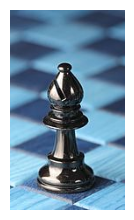


Class: king


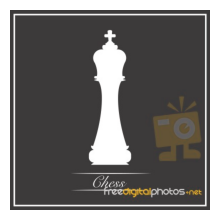


Class: knight


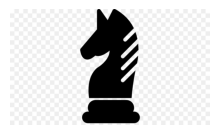


Class: pawn


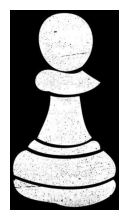


Class: queen


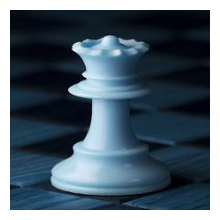


Class: rook


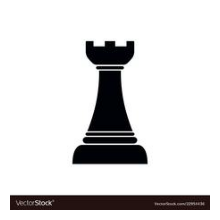

In [4]:
import matplotlib.pyplot as plt
import cv2

# function to display a raw image with matplotlib
import matplotlib.pyplot as plt

def display_image(img_array, max_size=2):
    """
    Displays an image at maximum size while preserving aspect ratio.
    Removes axes and margins for a clean look.

    :param img_array: NumPy array image (e.g. from OpenCV)
    :param max_size: Maximum size (in inches) for the longest side
    """
    h, w = img_array.shape[:2]
    scale = max_size / max(h, w)
    figsize = (w * scale, h * scale)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    ax.imshow(img_array, cmap='gray' if img_array.ndim == 2 else None, vmin=0, vmax=255)

    ax.set_axis_off()
    fig.patch.set_facecolor('none')
    ax.set_frame_on(False)
    plt.margins(0)
    plt.subplots_adjust(0, 0, 1, 1)

    plt.show()



for cls_dir in sorted(p for p in data_root.iterdir() if p.is_dir()):
    print(f"\nClass: {cls_dir.name}")

    images = sorted(cls_dir.glob("*"))[:1]
    for img_path in images:
        img = cv2.imread(str(img_path))
        if img is None:
            continue  # skip unreadable images
        display_image(img)



## Data Loading in fastai
The dataset is loaded using fastai’s ImageDataLoaders, which provides a high-level, reproducible pipeline for image loading, preprocessing, augmentation, and batching.

In [5]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(
    data_root,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=1.0)
)

To ensure that the data has been loaded correctly, we can visualize a batch of images along with their labels using the `show_batch` method.

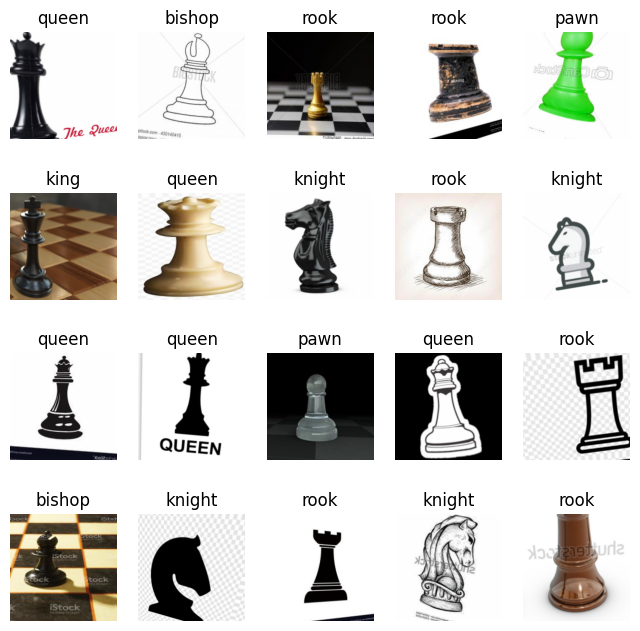

In [6]:
dls.show_batch(max_n=20, figsize=(8, 8))

## Model Training
### Transfer Learning with Pretrained CNN
To classify chess piece images, this project uses a pretrained image CNN (convoluted neural network) based on the ResNet34 architecture, rather than training a model from scratch. The fastai library makes it easy to leverage pretrained models using transfer learning.

The pretrained model has already learned how to extract useful visual information such as edges and shapes from images. In this project, it is reused to extract features from chess piece images, and a small classifier is trained on top of those features.

In [7]:
learn = vision_learner(
    dls,
    resnet34, # using a ResNet34 architecture
    metrics=accuracy
)

### Model Fine-Tuning
Fine-Tuning the model via transfer learning is done in two stages:

1. Only the final classification layer is trained.

2. The entire model is fine-tuned slightly using a tiny learning rate.

This approach allows good performance with a limited dataset and avoids the need to design a complex image model manually.

In [8]:
# Stage 1: Train only the final layer
learn.fit_one_cycle(5, lr_max=3e-3)

# Stage 2: Fine-tune the entire model
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))D

epoch,train_loss,valid_loss,accuracy,time
0,2.374401,1.047203,0.650000,02:14
1,1.548583,0.716398,0.770833,02:18
2,1.107650,0.500721,0.850000,02:17
3,0.835157,0.505324,0.858333,02:18
4,0.657350,0.511103,0.858333,02:23


epoch,train_loss,valid_loss,accuracy,time
0,0.314663,0.493738,0.870833,03:09
1,0.296109,0.458127,0.870833,03:10
2,0.257766,0.462151,0.870833,03:12
3,0.222631,0.449975,0.870833,03:08
4,0.195558,0.448328,0.870833,03:22


## Plot Training Curves
The training and validation loss curves can be plotted to visualize the model's learning progress over epochs. This is tracked automatically by fastai's Learner object, and plotting it helps in diagnosing overfitting or underfitting.

While validation loss remains relatively high (plateaus at ~0.45), validation accuracy reaches 87%, indicating that the model correctly classifies the majority of samples. However, the model clearly plateaued early on the training set and improvement wasn't made with further epochs.

The discrepancy between accuracy and loss suggests that misclassifications are associated with high confidence, or that correct predictions are made with low confidence, which is typical when using cross-entropy loss.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

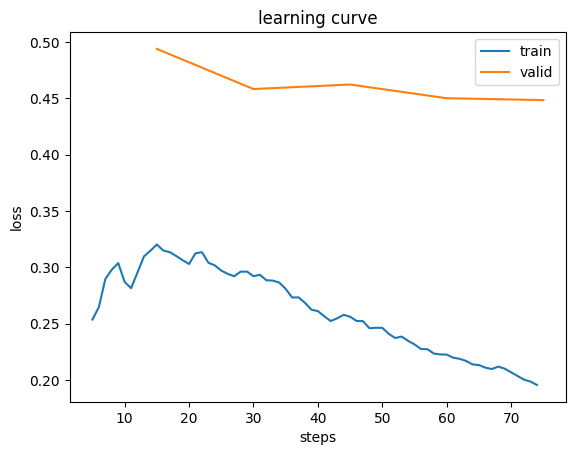

In [9]:
learn.recorder.plot_loss()

## Evaluation
### Confusion Matrix
To understand how the model performs across different classes, a confusion matrix is used.
This shows how often each chess piece is correctly classified and which classes are commonly confused.

The confusion matrix reveals that the model performs well overall, but there are some misclassifications between visually similar pieces, and especially in the king class. When combined with the training curves, this suggests that the model may benefit from additional or higher quality data rather than further training.

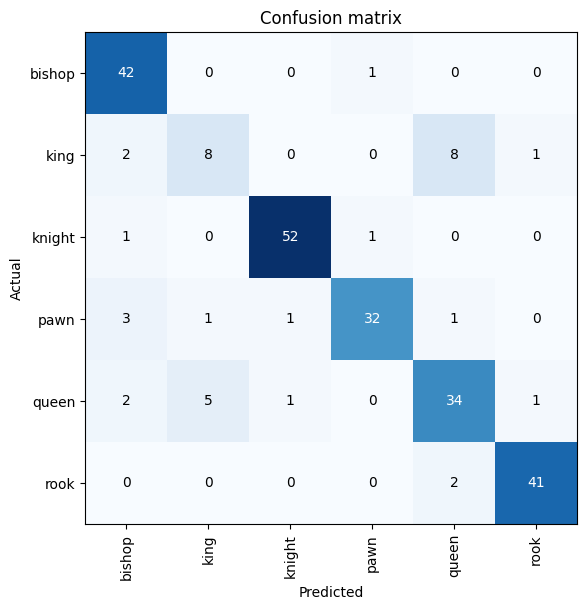

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6))

## Top Losses
To inspect the model’s most difficult cases, we use `plot_top_losses`, which displays images where the model made the most confident mistakes.

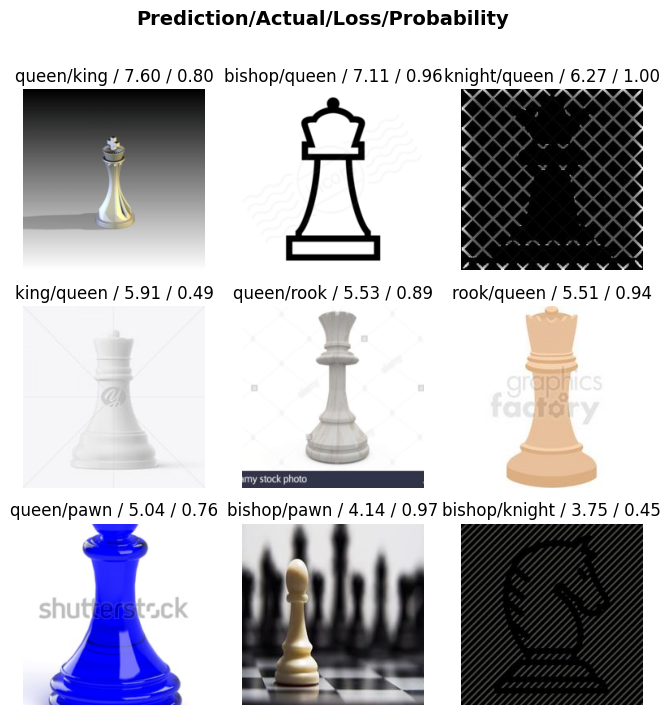

In [11]:
interp.plot_top_losses(9, figsize=(8, 8))

## Model Weaknesses
The primary weakness of the model is confusion between visually similar chess pieces, most notably the king and queen, and confusion regarding several images that are hard to guess due to being cutoff or having poor background. In many stylized icons and illustrations, the distinguishing features of certain pieces (such as the cross on the king) are reduced or omitted, leaving only a similar tall silhouette.

Overall, these errors suggest that the model relies mainly on overall outline and shape rather than fine-grained details, which is consistent with the heterogeneous nature of the dataset. Particularly, when it comes to the king, given the limited number of king examples compared to other classes, this confusion is expected. We can conclude that the high variance of the training data is what caused an early plateauing in the model's recognition. Overall, the observed weaknesses are understandable and reflect realistic challenges rather than systematic model failure.